In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches

In [100]:
figsize = (8, 4)
title_fontsize = 20
tick_label_fontsize = 14
legend_fontsize = 14
axis_label_fontsize = 16
text_fontsize = 18

# Actograms

In [101]:
hours_per_day = 24
colors_cmap = ["black", "gold"]
position = [0, 1]

custom_cmap = colors.LinearSegmentedColormap.from_list(
    "custom_cmap", list(zip(position, colors_cmap)))

In [102]:
def next_multiple_of_ten(n):
    return ((n + 9) // 10) * 10


def plot_actogram_double_plotted(light, sleep, dt, simulation_days,
                                 vmax=None, save_name=None, nancolor='lightgrey'):
    light = np.array(light)
    # Set sleep values to NaN in the light array for plotting purposes
    if sleep is not None:
        sleep = np.array(sleep)
        # Mask the light values during sleep
        light[sleep == 1] = np.nan  # Assuming sleep=1 indicates sleep period

    custom_cmap.set_bad(color=nancolor)  # Set color for NaNs

    if vmax is None:
        vmax = next_multiple_of_ten(np.nanmax(light))
    norm = colors.Normalize(vmin=0,
                    vmax=vmax)
    

    amplitude_delta = light
    amplitude_delta = amplitude_delta.reshape(-1, 1)

    scaled_data = amplitude_delta.reshape(
        (simulation_days, int(hours_per_day / dt))) # * dlmo_collection

    double_plotted_data = np.zeros(
        (simulation_days, int(hours_per_day / dt * 2)))

    # Last day does not have a "next day" to concatenate
    for day in range(simulation_days - 1):
        double_plotted_data[day] = np.concatenate(
            (scaled_data[day], scaled_data[day + 1]))
    double_plotted_data[-1] = np.concatenate(
        (scaled_data[-1], np.zeros_like(scaled_data[-1])))

    fig, ax = plt.subplots(figsize=figsize)

    # norm.autoscale_None([np.nan])  # Auto-scale to include NaN
    # Log norm including nan
    norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=0, vmax=vmax)
    norm.autoscale_None([np.nan])  # Auto-scale to include NaN

    cax = ax.imshow(double_plotted_data, aspect='auto',
                    cmap=custom_cmap, norm=norm , interpolation='none',
                    rasterized=True)


    # Adjust ticks for 48-hour x-axis
    dt_plot = 4
    x_ticks = np.arange(0, hours_per_day / dt * 2, dt_plot / dt)

    x_tick_labels = [str(int(x % hours_per_day))
                     for x in np.arange(0, hours_per_day * 2, dt_plot)]
    ax.set_xlabel('Local time', fontsize=axis_label_fontsize)
    ax.set_ylabel('Day', fontsize=axis_label_fontsize)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=tick_label_fontsize)

    day_step = 2
    ax.set_yticks(np.arange(0, simulation_days, day_step))
    ax.set_yticklabels(np.arange(1, simulation_days + 1, day_step),
                       fontsize=tick_label_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Cbar ticks
    cbar = fig.colorbar(cax, ax=ax, pad=0.01)

    cbar_label_numbers = [0, 0.1, 1, 10, 100, 1000, 5000]
    cbar.set_ticks(cbar_label_numbers)
    cbar_labels = [f"{x}" for x in cbar_label_numbers]

    cbar.set_ticklabels(cbar_labels)
    cbar.ax.tick_params(labelsize=tick_label_fontsize)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Light level (lux)', rotation=270, fontsize=axis_label_fontsize)


    # Cbar title fontsize and location
    cbar.ax.yaxis.label.set_fontsize(axis_label_fontsize)
    # cbar.ax.yaxis.set_label_coords(5.5, 0.5)

    # Make last day white as a white box
    rect_x = 24.0 / dt
    rect_y = 18.5
    rect_width = 24 / dt
    rect_height = 1.0
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=0, edgecolor='black', facecolor='white')
    ax.add_patch(rect)

    # Add a legend for nan values
    if nancolor is not None:
        legend_patch = patches.Patch(color=nancolor, label='Sleep')
        ax.legend(handles=[legend_patch], loc='upper right', fontsize=legend_fontsize,
                  bbox_to_anchor=(0.99, 1.2))
    
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
        core_save_name = save_name.split('.')[0]
        plt.savefig(f"{core_save_name}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

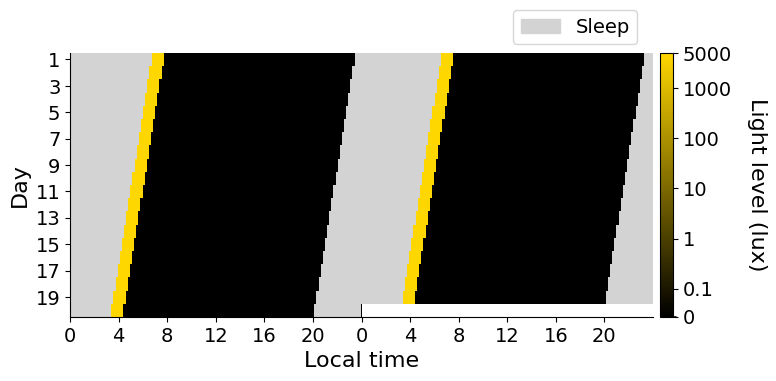

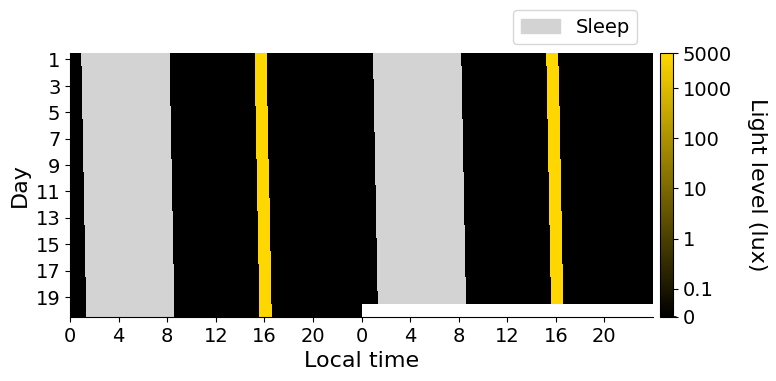

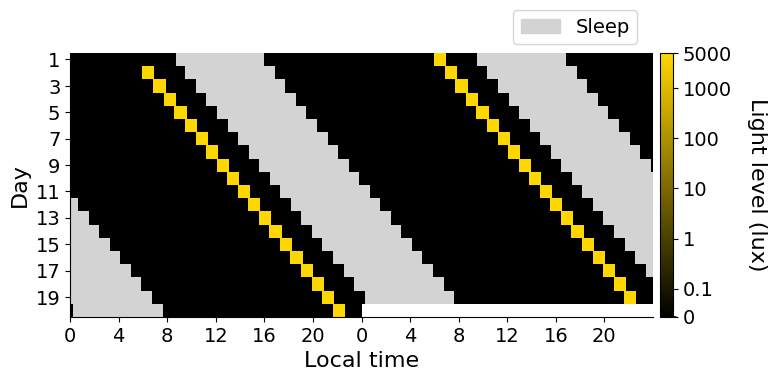

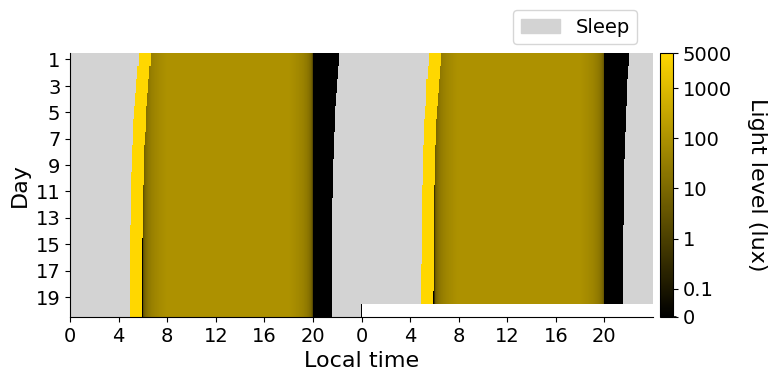

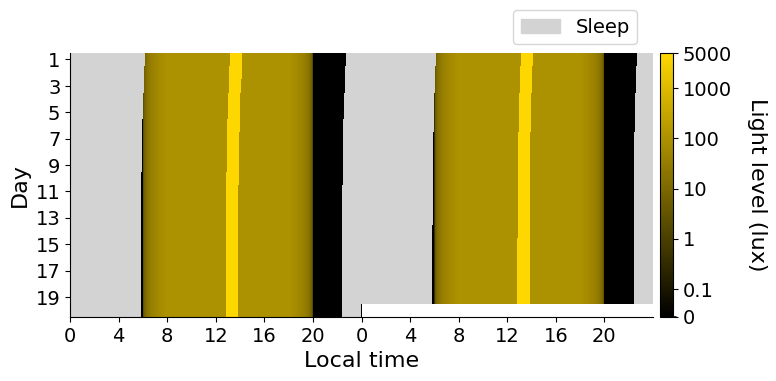

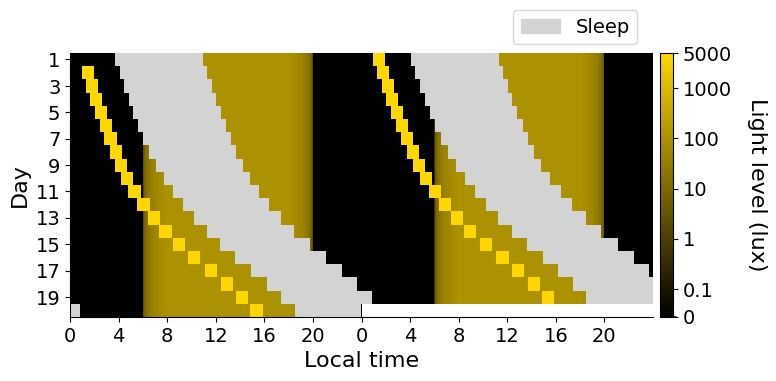

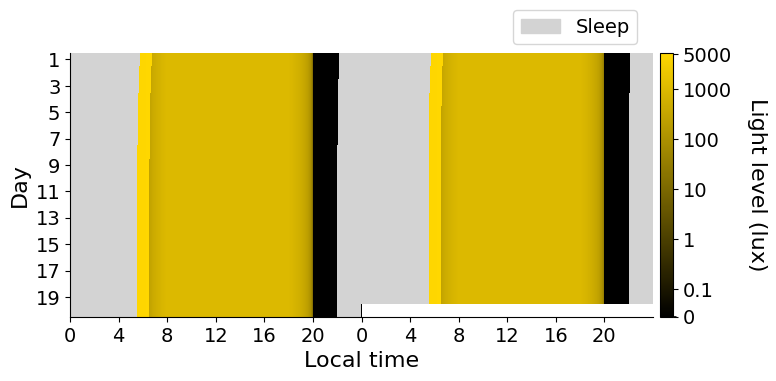

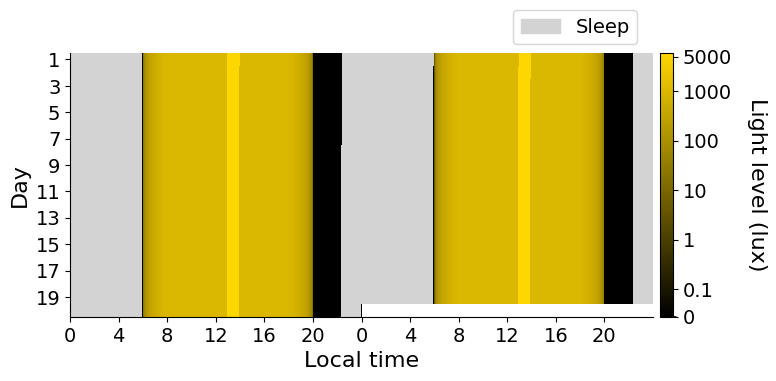

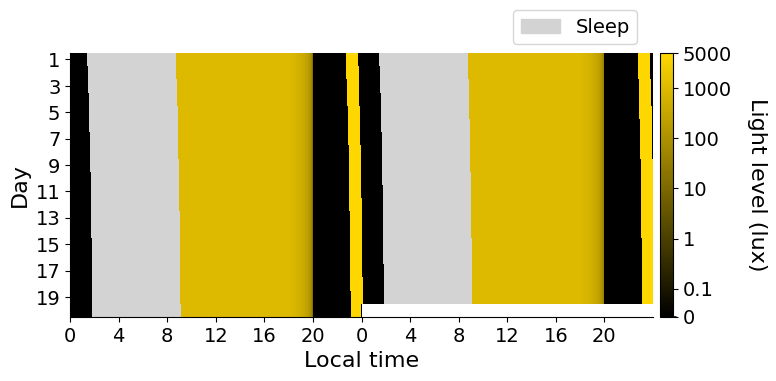

In [105]:
data_path = 'data/amplitude_simulations/'
fig_save_path = 'figures'

dt = 0.001
simulation_days = 20
last_day_start = int((simulation_days - 1) * 24 / dt)
day_length_in_idx = int(24.0 / dt) - 1
time_array = np.arange(0, simulation_days * 24, dt)  # Time array for the entire simulation

data_pairs_to_plot = [ # (baseline_lux, pulse_at)
    (0.0, 0.0), (0.0, 7.0), (0.0, 14.0),
    (100.0, 0.0), (100.0, 7.0), (100.0, 14.0),
    (1000.0, 0.0), (1000.0, 7.0), (1000.0, 14.0),

]
for (baseline_lux, pulse_at) in data_pairs_to_plot:
    data = np.load(f'{data_path}baseline_{baseline_lux}_pulse_at_{pulse_at}.npz')
    sol = data['sol']
    light = data['light_history']
    sleep = data['sleep_history']
    light = np.concatenate(([light[0]], light))
    save_name = f'{fig_save_path}/fig_3_baseline_lux_{baseline_lux}_pulse_at_{pulse_at}.png'
    plot_actogram_double_plotted(light, sleep, dt, simulation_days, save_name=save_name)